## Corresponding Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

- **Dataset**

In [3]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/USArrests.csv"
df = pd.read_csv(url)
df.head()

,Murder,Assault,UrbanPop,Rape,State
0,13.2,236,58,21.2,Alabama
1,10.0,263,48,44.5,Alaska
2,8.1,294,80,31.0,Arizona
3,8.8,190,50,19.5,Arkansas
4,9.0,276,91,40.6,California


In [4]:
df.shape

(50, 5)

- **EDA**

In [5]:
# Keep only the numeric columns used in classical demos
X = df[['Murder','Assault','UrbanPop','Rape']].copy()
states = df['Unnamed: 0'].rename('State') if 'Unnamed: 0' in df.columns else df.index.to_series().rename('State')

In [6]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0


- **Eigen value**

In [8]:
# Matrix of nonnegative values
A = X.to_numpy(dtype=float)

# Convert to relative frequencies (P) so CA works on profiles
grand_total = A.sum()
P = A / grand_total

# Row and column masses (marginals)
r = P.sum(axis=1, keepdims=True)        # (n_rows, 1)
c = P.sum(axis=0, keepdims=True)        # (1, n_cols)

In [9]:
# Expected under independence
rcT = r @ c   # outer product

# Diagonal mass matrices (as sqrt-inverses)
Dr_inv_sqrt = np.diag((r.flatten())**-0.5)
Dc_inv_sqrt = np.diag((c.flatten())**-0.5)

# Standardized residuals
S = Dr_inv_sqrt @ (P - rcT) @ Dc_inv_sqrt

In [10]:
U, s, Vt = np.linalg.svd(S, full_matrices=False)
eigvals = s**2                        # eigenvalues (principal inertias)
explained = eigvals / eigvals.sum()   # proportion of inertia

pd.DataFrame({
    'eigenvalue': eigvals,
    'explained_inertia_%': 100*explained
}).head(4)

,eigenvalue,explained_inertia_%
0,4.501357e-02,8.353547e+01
1,6.065461e-03,1.125619e+01
2,2.806548e-03,5.208347e+00
3,1.341215e-32,2.489005e-29


- **Visualization**

In [11]:

# Row principal coordinates F and column principal coordinates G
F = Dr_inv_sqrt @ U @ np.diag(s)   # rows (states)
G = Dc_inv_sqrt @ Vt.T @ np.diag(s) # columns (crime types)

# Keep first two dimensions for plotting
F2 = F[:, :2]
G2 = G[:, :2]

row_coords = pd.DataFrame(F2, columns=['Dim1','Dim2'])
row_coords.insert(0, 'State', list(states))
col_coords = pd.DataFrame(G2, columns=['Dim1','Dim2'])
col_coords.insert(0, 'Variable', X.columns)

row_coords.head(), col_coords

(   State      Dim1      Dim2
 0      0 -0.181415 -0.024962
 1      1 -0.224989  0.170053
 2      2 -0.129295 -0.019609
 3      3 -0.149569 -0.008356
 4      4 -0.047561  0.057339,
    Variable      Dim1      Dim2
 0    Murder -0.151595  0.085575
 1   Assault -0.140128 -0.021127
 2  UrbanPop  0.354758 -0.037788
 3      Rape  0.087510  0.255170)

In [12]:
# Row contributions to axis k: ctr_{ik} = r_i * F_{ik}^2 / λ_k
ctr_rows = (r * (F**2)) / eigvals
ctr_rows = pd.DataFrame(ctr_rows[:, :2], columns=['CTR_Dim1','CTR_Dim2'])
ctr_rows.insert(0, 'State', list(states))

# Column contributions to axis k: ctr_{jk} = c_j * G_{jk}^2 / λ_k
ctr_cols = (c.T * (G**2)) / eigvals
ctr_cols = pd.DataFrame(ctr_cols[:, :2], columns=['CTR_Dim1','CTR_Dim2'])
ctr_cols.insert(0, 'Variable', X.columns)

# COS² for rows/cols: share of a point's inertia carried by each axis
row_dist2 = (F**2).sum(axis=1, keepdims=True)
col_dist2 = (G**2).sum(axis=1, keepdims=True)
cos2_rows = (F2**2) / row_dist2
cos2_cols = (G2**2) / col_dist2

cos2_rows = pd.DataFrame(cos2_rows, columns=['COS2_Dim1','COS2_Dim2'])
cos2_rows.insert(0, 'State', list(states))
cos2_cols = pd.DataFrame(cos2_cols, columns=['COS2_Dim1','COS2_Dim2'])
cos2_cols.insert(0, 'Variable', X.columns)

ctr_rows.sort_values('CTR_Dim1', ascending=False).head(10), \
ctr_cols, \
cos2_rows.sort_values('COS2_Dim1', ascending=False).head(10), \
cos2_cols

(    State  CTR_Dim1  CTR_Dim2
 10     10  0.138273  0.029829
 32     32  0.091632  0.064574
 48     48  0.076853  0.006248
 23     23  0.051762  0.011832
 39     39  0.050754  0.003038
 14     14  0.049927  0.001140
 22     22  0.048342  0.000004
 28     28  0.045851  0.008443
 33     33  0.036955  0.009820
 1       1  0.030983  0.131357,
    Variable  CTR_Dim1  CTR_Dim2
 0    Murder  0.014986  0.035440
 1   Assault  0.280751  0.047361
 2  UrbanPop  0.690649  0.058154
 3      Rape  0.013614  0.859046,
     State  COS2_Dim1  COS2_Dim2
 22     22   0.998177   0.000012
 26     26   0.997005   0.000664
 14     14   0.996802   0.003068
 40     40   0.996705   0.002039
 3       3   0.996338   0.003110
 35     35   0.990549   0.004465
 8       8   0.990266   0.009261
 48     48   0.986939   0.010811
 15     15   0.983697   0.003851
 39     39   0.981176   0.007915,
    Variable  COS2_Dim1  COS2_Dim2
 0    Murder   0.194279   0.061909
 1   Assault   0.971805   0.022090
 2  UrbanPop   0.988413

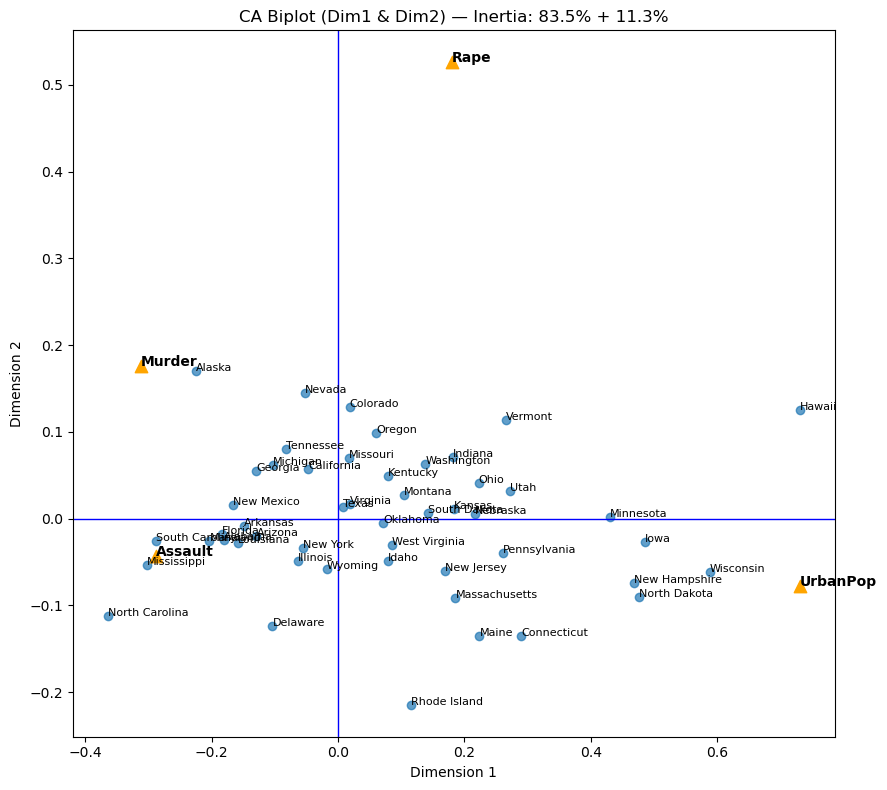

In [13]:
plt.figure(figsize=(9,8))

# Scale columns so both clouds fit nicely
scale = (np.abs(F2).max() / np.abs(G2).max()) if np.abs(G2).max() > 0 else 1.0
G2_plot = G2 * scale

# Ensure 'states' contains the actual names from the dataset
states = df['State']  # Column with state names

# Plot states (rows) with names instead of numbers
plt.scatter(F2[:,0], F2[:,1], alpha=0.7)
for i, name in enumerate(states):
    plt.text(F2[i,0], F2[i,1], name, fontsize=8)

# Plot variables (columns)
plt.scatter(G2_plot[:,0], G2_plot[:,1], marker='^', s=80, color="orange")
for j, var in enumerate(X.columns):
    plt.text(G2_plot[j,0], G2_plot[j,1], var, fontsize=10, fontweight='bold')

# Reference lines
plt.axhline(0, linewidth=1, color='blue')
plt.axvline(0, linewidth=1, color='blue')

# Titles and labels
plt.title(f"CA Biplot (Dim1 & Dim2) — Inertia: {explained[0]*100:.1f}% + {explained[1]*100:.1f}%")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.tight_layout()
plt.show()

**Interpretation:** The plot is a correspondence Analysis (CA) biplot that visualizes the relationship between different U.S. states and crime statistics, specifically Murder, Assault, Rape, and UrbanPop (urban population percentage).  
- The blue points indicates U.S. states and the orange triangles indicates variables: Murder, Assault, Rape, UrbanPop.
- States near the center (like Texas, Missouri, Georgia) have average or mixed crime statistics — no strong association with a specific variable.
- Top-right quadrant states leaning toward higher rape rates. Top-left quadrant states with high murder rates. Bottom-right quadrant states with high urban population. Bottom-left quadrant states with high assault rates.
- States like Hawaii, Wisconsin, Iowa, New Hampshire, North Dakota are close to it, suggesting these states have higher urban population percentages. No state is extremely close, but it is in the general direction of Vermont, Indiana, Ohio, Utah, suggesting slightly higher rates of rape relative to other crimes. Alaska is nearest, indicating relatively higher murder rates there. Mississippi, South Carolina are closer, indicating higher assault rates.

